Yhdistelmätekniikat
===
# Tehtävä 2 - Regressio
Hannu Karstu - TTV19SAI

## Tehtävänanto

Lisää tekemääsi lineaarisen regression tehtävään yhdistelmätekniikoita käyttävä regressio (Averaging, Stacking, Bagging ja Boosting). Minkälaisella kokoonpanolla saadaan paras tulos?
Refaktoroi koodia niin, että teet yleiskäyttöisen luokan regressio ongelmien ratkaisemiseen, joka käyttää yhdistelmätekniikoita regression toteuttamisessa.


## 1. Ladataan ja jaetaan data treeni- ja testiaineistoiksi

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline

In [2]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

In [3]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
boston['MEDV'] = boston_dataset.target

In [5]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


## 2. Tehdään yleiskäyttöinen luokka

In [7]:
# Kaiken maailman importit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from timeit import default_timer as timer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Luokittelijoiden määrittelyt
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=10, random_state=1)


# Regressoriluokka
class ultimateReg: 
    # Init
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.pred_vote = None
        self.pred_stacking = None
        
    # AVERAGING REGRESSOR
    def averagingReg(self):           
        # Nimi
        name = "averagingReg"
        
        # Ajastin päälle
        start = timer()     
        
        # Average regression määrittely
        #clf_avg = VotingRegressor([('lr', lin_reg), ('rf', rf_reg)])
        
        # Mallien sovitus
        model1 = DecisionTreeRegressor()
        model2 = KNeighborsRegressor()
        model3 = LinearRegression()
        
        model1.fit(self.X_train, self.y_train)
        model2.fit(self.X_train, self.y_train)
        model3.fit(self.X_train, self.y_train)    
        
        # Ennuste
        pred1 = model1.predict(self.X_test)
        pred2 = model2.predict(self.X_test)
        pred3 = model3.predict(self.X_test)
        
        finalpred = (pred1+pred2+pred3)/3
        
        # Ajastin kiinni
        end = timer()
                
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, finalpred, round(end-start, 2)    
        
    # VOTING REGRESSOR
    def votingReg(self):           
        # Nimi
        name = "votingReg"
        
        # Ajastin päälle
        start = timer()     
        
        # Äänestysregression määrittely
        clf_vote = VotingRegressor([('lr', lin_reg), ('rf', rf_reg)])
        
        # Mallin sovitus
        clf_vote.fit(self.X_train, self.y_train)
        
        # Ennuste
        self.pred_vote = clf_vote.predict(self.X_test)
        
        # Ajastin kiinni
        end = timer()
                
            
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, self.pred_vote, round(end-start, 2)
 

    # STACKING REGRESSOR
    def stackingReg(self):
        # Nimi
        name = "stackingReg"
               
        # Ajastin päälle
        start = timer()
        
        # Parametrit
        estimators = [
            ('lr', RidgeCV()),
            ('svr', LinearSVR(random_state=42))]

        # Stacking-regressorin määrittely
        clf_stacking = StackingRegressor(
            estimators=estimators,
            final_estimator=RandomForestRegressor(n_estimators=10,
                                                  random_state=42))
        
        # Mallin sovitus
        clf_stacking.fit(self.X_train,self.y_train)
        
        # Ennuste
        pred_stacking = clf_stacking.predict(self.X_test)
                       
        # Ajastin kiinni
        end = timer()
        
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, pred_stacking, round(end-start, 2)
    
    
    # BAGGING REGRESSOR
    def baggingReg(self):
        # Nimi
        name = "baggingReg"
               
        # Ajastin päälle
        start = timer()
        
        # Bagging-lajittelijan määrittely
        clf_bagging = BaggingRegressor(base_estimator=SVR(),
                        n_estimators=10, random_state=0)
        
        # Mallin sovitus
        clf_bagging.fit(self.X_train,self.y_train)
        
        # Ennuste
        pred_bagging = clf_bagging.predict(self.X_test)
                       
        # Ajastin kiinni
        end = timer()
        
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, pred_bagging, round(end-start, 2)
    
    
    # ADABOOST REGRESSOR
    def adaboostReg(self):
        # Nimi
        name = "adaboostReg"
               
        # Ajastin päälle
        start = timer()
        
                
        # Adaboost-lajittelijan määrittely
        clf_adaboost = AdaBoostRegressor(random_state=0, n_estimators=100)
        
        # Mallin sovitus
        clf_adaboost.fit(self.X_train,self.y_train)
        
        # Ennuste
        pred_adaboost = clf_adaboost.predict(self.X_test)
                       
        # Ajastin kiinni
        end = timer()
        
        # Palautetaan luokittelijan nimi, ennuste ja kulunut aika
        return name, pred_adaboost, round(end-start, 2)

## 3. Luokittelut

In [8]:
# Annetaan ultimateClassifierille datat
ucf = ultimateReg(X_train, y_train, X_test, y_test)

### Luodaan lista johon kerätään:
 - luokittelijan nimi
 - rmse
 - r2
 - mallin sovitukseen ja ennustukseen kulunut aika

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

lista = []

### Averaging Regressor

In [10]:
name, pred, time = ucf.averagingReg()

rmse = (np.sqrt(mean_squared_error(ucf.y_test, pred)))
r2 = r2_score(ucf.y_test, pred)

malli = [name,rmse,r2,time]

lista.append(malli)
print(malli)

['averagingReg', 4.283085228875125, 0.765692775419203, 0.01]


### Voting Regressor

In [11]:
name, pred, time = ucf.votingReg()

rmse = (np.sqrt(mean_squared_error(ucf.y_test, pred)))
r2 = r2_score(ucf.y_test, pred)

malli = [name,rmse,r2,time]

lista.append(malli)
print(malli)

['votingReg', 4.190964267301935, 0.7756633848797534, 0.03]


### Stacking Regressor

In [12]:
name, pred, time = ucf.stackingReg()

rmse = (np.sqrt(mean_squared_error(ucf.y_test, pred)))
r2 = r2_score(ucf.y_test, pred)

malli = [name,rmse,r2,time]

lista.append(malli)
print(malli)

['stackingReg', 4.6785684713570745, 0.7204250689944274, 0.09]


### Bagging Regressor

In [13]:
name, pred, time = ucf.baggingReg()

rmse = (np.sqrt(mean_squared_error(ucf.y_test, pred)))
r2 = r2_score(ucf.y_test, pred)

malli = [name,rmse,r2,time]

lista.append(malli)
print(malli)

['baggingReg', 5.298401875929541, 0.6414398355398176, 0.06]


### AdaBoost Regressor

In [14]:
name, pred, time = ucf.adaboostReg()

rmse = (np.sqrt(mean_squared_error(ucf.y_test, pred)))
r2 = r2_score(ucf.y_test, pred)

malli = [name,rmse,r2,time]

lista.append(malli)
print(malli)

['adaboostReg', 4.712045345429577, 0.7164098325345304, 0.03]


## 4. Laitetaan saadut arvot Pandasin dataframeen

In [15]:
import pandas as pd

df = pd.DataFrame(data=lista)
df = df.rename(columns={0: 'luokittelija', 1: 'rmse', 2: 'r2', 3: 'aika (s)'})

### Järjestettynä r2 mukaan
- R2 suurin = optimaalisin

In [16]:
df = df.sort_values(by=['r2'], ascending=False)
df

,luokittelija,rmse,r2,aika (s)
1,votingReg,4.190964,0.775663,0.03
0,averagingReg,4.283085,0.765693,0.01
2,stackingReg,4.678568,0.720425,0.09
4,adaboostReg,4.712045,0.716410,0.03
3,baggingReg,5.298402,0.641440,0.06


### Järjestettynä rmse mukaan
- RMSE pienin = optimaalisin

In [17]:
df = df.sort_values(by=['rmse'], ascending=True)
df

,luokittelija,rmse,r2,aika (s)
1,votingReg,4.190964,0.775663,0.03
0,averagingReg,4.283085,0.765693,0.01
2,stackingReg,4.678568,0.720425,0.09
4,adaboostReg,4.712045,0.716410,0.03
3,baggingReg,5.298402,0.641440,0.06


### Järjestettynä ajan mukaan

In [18]:
df = df.sort_values(by=['aika (s)'], ascending=True)
df

,luokittelija,rmse,r2,aika (s)
0,averagingReg,4.283085,0.765693,0.01
1,votingReg,4.190964,0.775663,0.03
4,adaboostReg,4.712045,0.716410,0.03
3,baggingReg,5.298402,0.641440,0.06
2,stackingReg,4.678568,0.720425,0.09


## 5. Plotataan regressorit

In [19]:
markers = ["o","s","p","h","D"]

Text(0, 0.5, 'aika (s)')

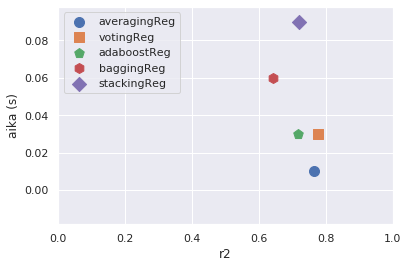

In [20]:
for i in range (0, len(df)):
    plt.scatter(df['r2'].iloc[i],df['aika (s)'].iloc[i], label=df['luokittelija'].iloc[i], marker=markers[i],s=100)
    

plt.legend()
plt.xlim(0, 1);
plt.xlabel('r2')
plt.ylabel('aika (s)')

Text(0, 0.5, 'aika (s)')

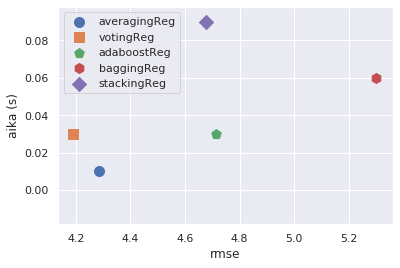

In [21]:
for i in range (0, len(df)):
    plt.scatter(df['rmse'].iloc[i],df['aika (s)'].iloc[i], label=df['luokittelija'].iloc[i], marker=markers[i],s=100)
    

plt.legend()
plt.xlabel('rmse')
plt.ylabel('aika (s)')

Text(0, 0.5, 'rmse')

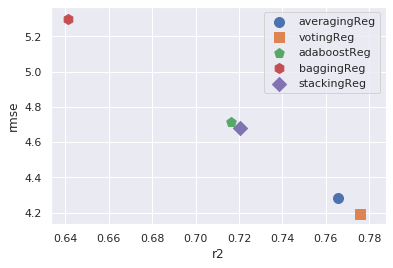

In [22]:
for i in range (0, len(df)):
    plt.scatter(df['r2'].iloc[i],df['rmse'].iloc[i], label=df['luokittelija'].iloc[i], marker=markers[i],s=100)
    

plt.legend()
plt.xlabel('r2')
plt.ylabel('rmse')